# Cleaning Data in Python
Run the hidden code cell below to import the data used in this course.

In [1]:
# Import the course packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import missingno as msno
import fuzzywuzzy
import recordlinkage 

# Import the course datasets
ride_sharing = pd.read_csv('datasets/ride_sharing_new.csv', index_col = 'Unnamed: 0')
airlines = pd.read_csv('datasets/airlines_final.csv',  index_col = 'Unnamed: 0')
banking = pd.read_csv('datasets/banking_dirty.csv', index_col = 'Unnamed: 0')
restaurants = pd.read_csv('datasets/restaurants_L2.csv', index_col = 'Unnamed: 0')
restaurants_new = pd.read_csv('datasets/restaurants_L2_dirty.csv', index_col = 'Unnamed: 0')

## Explore Datasets
Use the DataFrames imported in the first cell to explore the data and practice your skills!
- For each DataFrame, inspect the data types of each column and, where needed, clean and convert columns into the correct data type. You should also rename any columns to have more descriptive titles.
- Identify and remove all the duplicate rows in `ride_sharing`.
- Inspect the unique values of all the columns in `airlines` and clean any inconsistencies.
- For the `airlines` DataFrame, create a new column called `International` from `dest_region`, where values representing US regions map to `False` and all other regions map to `True`.
- The `banking` DataFrame contains out of date ages. Update the `Age` column using today's date and the `birth_date` column.
- Clean the `restaurants_new` DataFrame so that it better matches the categories in the `city` and `type` column of the `restaurants` DataFrame. Afterward, given typos in restaurant names, use record linkage to generate possible pairs of rows between `restaurants` and `restaurants_new` using criteria you think is best.


## Common Data Problems
* In this chapter, you'll learn how to overcome some of the most common dirty data problems. You'll convert data types, apply range constraints to remove future data points, and remove duplicated data points to avoid double-counting.

```python
# Sample Revenue Sum Column
sales['Revenue'].sum()
// '231543$3189$3890$389903$3134934$'

# Remove $ from column
sales['Revenue'] = sales['Revenue'].str.strip('$')
sales['Revenue'] = sales['Revenue'].astype('int')

# Verify column value
assert sales['Revenue'].dtype == 'int'
 ```

### Numeric data or ... ?
In this exercise, and throughout this chapter, you'll be working with bicycle ride sharing data in San Francisco called ride_sharing. It contains information on the start and end stations, the trip duration, and some user information for a bike sharing service.

* The user_type column contains information on whether a user is taking a free ride and takes on the following values:
1. for free riders.
2. for pay per ride.
3. for monthly subscribers.

In [2]:
ride_sharing.head()

,duration,station_A_id,station_A_name,station_B_id,station_B_name,bike_id,user_type,user_birth_year,user_gender
0,12 minutes,81,Berry St at 4th St,323,Broadway at Kearny,5480,2,1959,Male
1,24 minutes,3,Powell St BART Station (Market St at 4th St),118,Eureka Valley Recreation Center,5193,2,1965,Male
2,8 minutes,67,San Francisco Caltrain Station 2 (Townsend St...,23,The Embarcadero at Steuart St,3652,3,1993,Male
3,4 minutes,16,Steuart St at Market St,28,The Embarcadero at Bryant St,1883,1,1979,Male
4,11 minutes,22,Howard St at Beale St,350,8th St at Brannan St,4626,2,1994,Male


In [3]:
# Print the information of ride_sharing
print(ride_sharing.info(), '\n')

# Print summary statistics of user_type column
print(ride_sharing['user_type'].describe(), '\n')

# Convert user_type from integer to category
ride_sharing['user_type_cat'] = ride_sharing['user_type'].astype('category')

# Write an assert statement confirming the change
assert ride_sharing['user_type_cat'].dtype == 'category'

# Print new summary statistics 
print(ride_sharing['user_type_cat'].describe())

# Raise assertion error for previous dtype
# assert ride_sharing['user_type_cat'].dtype == 'int'

# AssertionError                            Traceback (most recent call last)
# Input In [3], in <cell line: 17>()
#      14 print(ride_sharing['user_type_cat'].describe())
#      16 # Raise assertion error for previous dtype
# ---> 17 assert ride_sharing['user_type_cat'].dtype == 'int'

# AssertionError

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25760 entries, 0 to 25759
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   duration         25760 non-null  object
 1   station_A_id     25760 non-null  int64 
 2   station_A_name   25760 non-null  object
 3   station_B_id     25760 non-null  int64 
 4   station_B_name   25760 non-null  object
 5   bike_id          25760 non-null  int64 
 6   user_type        25760 non-null  int64 
 7   user_birth_year  25760 non-null  int64 
 8   user_gender      25760 non-null  object
dtypes: int64(5), object(4)
memory usage: 2.0+ MB
None 

count    25760.000000
mean         2.008385
std          0.704541
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: user_type, dtype: float64 

count     25760
unique        3
top           2
freq      12972
Name: user_type_cat, dtype: int64


### Summing strings and concatenating numbers
In the previous exercise, you were able to identify that category is the correct data type for user_type and convert it in order to extract relevant statistical summaries that shed light on the distribution of user_type.

Another common data type problem is importing what should be numerical values as strings, as mathematical operations such as summing and multiplication lead to string concatenation, not numerical outputs.

In [4]:
# Check Duration Minutes
print(ride_sharing['duration'].dtype, '\n')

# Sample outputs 
print(ride_sharing['duration'][:5], '\n')

# Strip duration of minutes
ride_sharing['duration_trim'] = ride_sharing['duration'].str.strip('minutes')

# Convert duration to integer
ride_sharing['duration_time'] = ride_sharing['duration_trim'].astype('int')

# Write an assert statement making sure of conversion
assert ride_sharing['duration_time'].dtype == 'int'

# Print formed columns and calculate average ride duration 
print(ride_sharing[['duration', 'duration_trim', 'duration_time']].head(), '\n')
print(ride_sharing['duration_time'].describe())

object 

0    12 minutes
1    24 minutes
2     8 minutes
3     4 minutes
4    11 minutes
Name: duration, dtype: object 

     duration duration_trim  duration_time
0  12 minutes           12              12
1  24 minutes           24              24
2   8 minutes            8               8
3   4 minutes            4               4
4  11 minutes           11              11 

count    25760.000000
mean        11.389053
std         23.500516
min          1.000000
25%          6.000000
50%          9.000000
75%         13.000000
max       1372.000000
Name: duration_time, dtype: float64


* 11 minutes is really not bad for an average ride duration in a city like San-Francisco. In the next lesson, you're going to jump right ahead into sanity checking the range of values in your data.

### Tire Size Constraints
Bicycle tire sizes could be either 26″, 27″ or 29″ and are here correctly stored as a categorical value. In an effort to cut maintenance costs, the ride sharing provider decided to set the maximum tire size to be 27″.

In this exercise, you will make sure the tire_sizes column has the correct range by first converting it to an integer, then setting and testing the new upper limit of 27″ for tire sizes.

In [5]:
ride_sharing['tire_sizes'] = [27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 27.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 29.0, 29.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 29.0, 29.0, 29.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 29.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 29.0, 29.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 29.0, 27.0, 29.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 29.0, 29.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 29.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 29.0, 29.0, 29.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 27.0, 29.0, 29.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 29.0, 27.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 29.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 29.0, 29.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 27.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 27.0, 27.0, 27.0, 29.0, 29.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 29.0, 29.0, 29.0, 26.0, 29.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 29.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 29.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 29.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 29.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 29.0, 29.0, 27.0, 29.0, 29.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 27.0, 29.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 29.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 29.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 29.0, 29.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 27.0, 29.0, 29.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 27.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 27.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 29.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 29.0, 29.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 29.0, 27.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 29.0, 26.0, 29.0, 27.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 29.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 29.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 29.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 29.0, 29.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 27.0, 29.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 29.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 29.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 27.0, 29.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 29.0, 27.0, 26.0, 29.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 29.0, 29.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 29.0, 29.0, 29.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 29.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 29.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 29.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 29.0, 29.0, 29.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 29.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 26.0, 29.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 27.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 29.0, 27.0, 29.0, 29.0, 29.0, 29.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 27.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 27.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 29.0, 26.0, 29.0, 29.0, 29.0, 26.0, 26.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 29.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 29.0, 26.0, 27.0, 29.0, 26.0, 29.0, 26.0, 29.0, 29.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 26.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 26.0, 27.0, 26.0, 27.0, 29.0, 29.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 29.0, 26.0, 26.0, 27.0, 26.0, 29.0, 27.0, 27.0, 27.0, 27.0, 29.0, 29.0, 29.0, 27.0, 29.0, 26.0, 29.0, 29.0, 29.0, 27.0, 27.0, 29.0, 29.0, 27.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 29.0, 26.0, 29.0, 29.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 26.0, 29.0, 29.0, 27.0, 29.0, 29.0, 29.0, 29.0, 26.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 27.0, 26.0, 29.0, 26.0, 27.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 29.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 29.0, 27.0, 29.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 27.0, 27.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 27.0, 27.0, 29.0, 27.0, 27.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 27.0, 26.0, 26.0, 27.0, 27.0, 26.0, 29.0, 26.0, 26.0, 26.0, 27.0, 26.0, 26.0, 29.0, 29.0, 27.0, 26.0, 29.0, 29.0, 27.0, 27.0, 29.0, 26.0, 26.0, 27.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 27.0, 26.0, 27.0, 26.0, 29.0, 26.0, 29.0, 26.0, 27.0]
ride_sharing['tire_sizes'] = ride_sharing['tire_sizes'].astype('category')
print(ride_sharing['tire_sizes'].dtype)
print(ride_sharing['tire_sizes'].describe())

category
count     25760.0
unique        3.0
top          26.0
freq      12486.0
Name: tire_sizes, dtype: float64


In [6]:
# Convert the tire_sizes column from category to 'int' (ovename current column)
ride_sharing['tire_sizes'] = ride_sharing['tire_sizes'].astype('int')

# Use .loc[] to set all values of tire_sizes above 27 to 27.
ride_sharing.loc[ride_sharing['tire_sizes'] > 27, 'tire_sizes'] = 27

# Reconvert back tire_sizes to 'category' from int
ride_sharing['tire_sizes'] = ride_sharing['tire_sizes'].astype('category')

# Print the description of the tire_sizes
print(ride_sharing['tire_sizes'].describe(), '\n', ride_sharing['tire_sizes'].value_counts())

count     25760
unique        2
top          27
freq      13274
Name: tire_sizes, dtype: int64 
 27    13274
26    12486
Name: tire_sizes, dtype: int64


### Back to the future
A new update to the data pipeline feeding into the ride_sharing DataFrame has been updated to register each ride's date. This information is stored in the `ride_date` column of the type object, which represents strings in pandas.

#### Exercise
* A bug was discovered which was relaying rides taken today as taken next year. To fix this, you will find all instances of the ride_date column that occur anytime in the future, and set the maximum possible value of this column to today's date. Before doing so, you would need to convert ride_date to a datetime object.

```python
# Import datetime
from datetime import datetime as dt
ride_sharing['ride_dt'] = pd.to_datetime(ride_sharing['ride_date'])
print(ride_sharing['ride_dt'].head(), '\n', ride_sharing['ride_dt'].dtype)

# Below access type is using 
0   2020-01-19
1   2018-10-24
2   2017-12-25
3   2024-03-09
4   2019-01-29
Name: ride_dt, dtype: datetime64[ns] 
 datetime64[ns]
  
# Using datetime .dt return attributes for string/object type setting
ride_sharing['ride_dt'] = pd.to_datetime(ride_sharing['ride_date']).dt.date
print(ride_sharing['ride_dt'].head(), '\n', ride_sharing['ride_dt'].dtype)

0    2020-01-19
1    2018-10-24
2    2017-12-25
3    2024-03-09
4    2019-01-29
Name: ride_dt, dtype: object 
 object
```

```python
# Convert ride_date to a datetime object using to_datetime(), then convert the datetime object into a date and store it in ride_dt column.
ride_sharing['ride_dt'] = pd.to_datetime(ride_sharing['ride_date']).dt.date

# Create the variable today, which stores today's date by using the dt.date.today() function
today = dt.date.today()

# For all instances of ride_dt in the future, set them to today's date
ride_sharing.loc[ride_sharing['ride_dt'] > today, 'ride_dt'] = today

# Print the maximum date in the ride_dt column.
print(ride_sharing['ride_dt'].max())

2023-03-10
```

### Finding duplicates
A new update to the data pipeline feeding into ride_sharing has added the ride_id column, which represents a unique identifier for each ride.

The update however coincided with radically shorter average ride duration times and irregular user birth dates set in the future. Most importantly, the number of rides taken has increased by 20% overnight, leading you to think there might be both complete and incomplete duplicates in the ride_sharing DataFrame.

In this exercise, you will confirm this suspicion by finding those duplicates. A sample of ride_sharing is in your environment, as well as all the packages you've been working with thus far.

```python
# Find duplicated rows of ride_id in the ride_sharing DataFrame while setting keep to False. (mark all dupes as true)
duplicates = ride_sharing.duplicated(subset='ride_id', keep=False)

# Subset ride_sharing on duplicates and sort by ride_id and assign the results to duplicated_ride
duplicated_ride = ride_sharing[duplicates].sort_values(by='ride_id')

# Print relevant columns of duplicated_rides
print(duplicated_rides[['ride_id','duration','user_birth_year']])

    ride_id  duration  user_birth_year
22       33        10             1979
39       33         2             1979
53       55         9             1985
65       55         9             1985
74       71        11             1997
75       71        11             1997
76       89         9             1986
77       89         9             2060

# Check Boolean Series for duplicates boolean series length equaling total of original dataframe w/dupes
# Use loc conditional setting with boolean duplicates series for assertion
assert len(duplicates.loc[~duplicates == True]) + len(duplicates.loc[duplicates]) == ride_sharing.shape[0]
```

### Treating duplicates
In the last exercise, you were able to verify that the new update feeding into ride_sharing contains a bug generating both complete and incomplete duplicated rows for some values of the ride_id column, with occasional discrepant values for the user_birth_year and duration columns.

In this exercise, you will be treating those duplicated rows by first dropping complete duplicates, and then merging the incomplete duplicate rows into one while keeping the average duration, and the minimum user_birth_year for each set of incomplete duplicate rows.

```python
# Drop complete duplicates in ride_sharing and store the results in ride_dup. (assigning returned Dataframe to ride_dup, not replacing original dframe inplace)
ride_dup = ride_sharing.drop_duplicates()

# Create the statistics dictionary which holds minimum aggregation for user_birth_year and mean aggregation for duration.
statistics = {'user_birth_year': 'min', 'duration': 'mean'}

# Drop incomplete duplicates by grouping by ride_id (will only have multiple values for dupes) and applying the aggregation in statistics.
ride_unique = ride_dup.groupby('ride_id').agg(statistics).reset_index()

# Find duplicated values again
duplicates = ride_unique.duplicated(subset = 'ride_id', keep = False)
duplicated_rides = ride_unique[duplicates == True]

# Assert duplicates are processed
assert duplicated_rides.shape[0] == 0
```

```python
# look at aggregated values from duplicate rows original values
print(ride_sharing.loc[ride_sharing['ride_id'].isin([55, 33, 71, 89]), ['ride_id', 'user_birth_year', 'duration']], '\n')

# See which of the ride_ids had duplicate values
print(ride_sharing.groupby('ride_id')['ride_id'].count().sort_values(ascending=False)[:5], '\n')

# Look at ride_id values in ride_unique dataframe which applied 'min' and 'mean' methods for multiple rows on the key columns in stats
print(ride_unique.loc[ride_unique['ride_id'].isin([55,33, 71, 89]),['ride_id','user_birth_year','duration']])

# Duplicate ride_id rows from ride_sharing original
    ride_id  user_birth_year  duration
22       33             1979        10
39       33             1979         2
53       55             1985         9
65       55             1985         9
74       71             1997        11
75       71             1997        11
76       89             1986         9
77       89             2060         9 

# Groupby counts on ride_id from original dataframe to see which ride_id have multiple rows in original dataframe using the count method on the ride_id after grouping by ride_id
ride_id
55    2
33    2
71    2
89    2
59    1
Name: ride_id, dtype: int64 

# Looking at the adjusted value for the stats column agg functions called on columns for multiple grouped by rows with same ride_id
    ride_id  user_birth_year  duration
22       33             1979       6.0
39       55             1985       9.0
53       71             1997      11.0
65       89             1986       9.0
```

## Text and Categorical Data Problems
Categorical and text data can often be some of the messiest parts of a dataset due to their unstructured nature. In this chapter, you’ll learn how to fix whitespace and capitalization inconsistencies in category labels, collapse multiple categories into one, and reformat strings for consistency.


### Finding consistency
In this exercise and throughout this chapter, you'll be working with the `airlines` DataFrame which contains survey responses on the San Francisco Airport from airline customers.

The DataFrame contains flight metadata such as the airline, the destination, waiting times as well as answers to key questions regarding cleanliness, safety, and satisfaction. Another DataFrame named categories was created, containing all correct possible values for the survey columns.


In [7]:
# Need to make the categories dataframe used in the upcoming exercises
categories = pd.DataFrame({
    'cleanliness':['Clean', 'Average', 'Somewhat clean', 'Somewhat dirty', 'Dirty'],
    'Safety':['Neutral', 'Very safe', 'Somewhat safe', 'Very unsafe', 'Somewhat unsafe'],
    'Satisfaction':['Very satisfied', 'Neutral', 'Somewhat satisfied', 'Somewhat unsatisfied', 'Very unsatisfied']
}) #dtype='category' potentially for later
print(categories.info())
categories.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cleanliness   5 non-null      object
 1   Safety        5 non-null      object
 2   Satisfaction  5 non-null      object
dtypes: object(3)
memory usage: 248.0+ bytes
None


,cleanliness,Safety,Satisfaction
0,Clean,Neutral,Very satisfied
1,Average,Very safe,Neutral
2,Somewhat clean,Somewhat safe,Somewhat satisfied
3,Somewhat dirty,Very unsafe,Somewhat unsatisfied
4,Dirty,Somewhat unsafe,Very unsatisfied


In [8]:
airlines_categorical = airlines.copy()
# Set columns to categorical to match exercise dtypes
airlines_categorical[['cleanliness', 'safety', 'satisfaction']] = airlines_categorical[['cleanliness', 'safety', 'satisfaction']].apply(lambda x: x.astype('category'))
airlines_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2808
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             2477 non-null   int64   
 1   day            2477 non-null   object  
 2   airline        2477 non-null   object  
 3   destination    2477 non-null   object  
 4   dest_region    2477 non-null   object  
 5   dest_size      2477 non-null   object  
 6   boarding_area  2477 non-null   object  
 7   dept_time      2477 non-null   object  
 8   wait_min       2477 non-null   float64 
 9   cleanliness    2477 non-null   category
 10  safety         2477 non-null   category
 11  satisfaction   2477 non-null   category
dtypes: category(3), float64(1), int64(1), object(7)
memory usage: 201.4+ KB


In [9]:
# Add new category value to category type column (cleanliness)
airlines_categorical['cleanliness'] = airlines_categorical['cleanliness'].cat.add_categories('Unacceptable')

# These Index values were made to me unacceptable in the exercise so changing for my dataset
airlines_categorical.loc[airlines_categorical.index.isin([4, 18, 100]), 'cleanliness'] = 'Unacceptable'

In [10]:
# Find the cleanliness category in airlines not in categories
cat_clean = set(airlines_categorical['cleanliness']).difference(categories['cleanliness'])
print(cat_clean)

# Find rows with that category
cat_clean_rows = airlines_categorical['cleanliness'].isin(cat_clean)

# Print rows with inconsistent category
print(airlines_categorical[cat_clean_rows])

{'Unacceptable'}
       id        day  ...         safety        satisfaction
4    2992  Wednesday  ...      Very safe  Somewhat satsified
18   2913     Friday  ...      Very safe  Somewhat satsified
100  2321  Wednesday  ...  Somewhat safe  Somewhat satsified

[3 rows x 12 columns]


In [11]:
# Print rows with consistent categories only (~ gets inverse of all True values in cat_clean_rows boolean series)
print(airlines_categorical[~cat_clean_rows][['day', 'safety', 'cleanliness']].head(), '\n')
# Check Boolean Series to confirm
print(cat_clean_rows.head())

        day         safety     cleanliness
0   Tuesday        Neutral           Clean
1    Friday      Very safe           Clean
2  Thursday  Somewhat safe         Average
3   Tuesday      Very safe           Clean
5  Thursday      Very safe  Somewhat clean 

0    False
1    False
2    False
3    False
4     True
Name: cleanliness, dtype: bool


## Collapsing Data into Categories
* Create categories out of data
```python
# using cut - create category and ranges
ranges = [0, 200000, 500000, np.inf]
group_names = ['0-200K', '200K-500K', '500K+']
# It takes in a list of cutoff points for each category, with the final one being infinity represented with np-dot-inf().
demographics['income_group'] = pd.cut(demographics['income_group'], bins=ranges, labels=group_names)

```

In [12]:
[airlines[x].unique() for x in ['dest_region', 'dest_size']]

[array(['Asia', 'Canada/Mexico', 'West US', 'East US', 'Midwest US',
        'EAST US', 'Middle East', 'Europe', 'eur', 'Central/South America',
        'Australia/New Zealand', 'middle east'], dtype=object),
 array(['Hub', 'Small', '    Hub', 'Medium', 'Large', 'Hub     ',
        '    Small', 'Medium     ', '    Medium', 'Small     ',
        '    Large', 'Large     '], dtype=object)]

In [13]:
# modify an instance of values in airlines
airlines_col_clean = airlines.copy()

# Change the capitalization of all values of dest_region to lowercase.
airlines_col_clean['dest_region'] = airlines_col_clean['dest_region'].str.lower()

# Replace the 'eur' with 'europe' in dest_region using the .replace() method (can change one without impacting the others)
airlines_col_clean['dest_region'] = airlines_col_clean['dest_region'].replace({'eur': 'europe'})
print(airlines_col_clean['dest_region'].unique())

['asia' 'canada/mexico' 'west us' 'east us' 'midwest us' 'middle east'
 'europe' 'central/south america' 'australia/new zealand']


### Remapping categories
To better understand survey respondents from airlines, you want to find out if there is a relationship between certain responses and the day of the week and wait time at the gate.

The airlines DataFrame contains the day and wait_min columns, which are categorical and numerical respectively. The day column contains the exact day a flight took place, and wait_min contains the amount of minutes it took travelers to wait at the gate. To make your analysis easier, you want to create two new categorical variables:

wait_type: 'short' for 0-60 min, 'medium' for 60-180 and long for 180+
day_week: 'weekday' if day is in the weekday, 'weekend' if day is in the weekend.

In [14]:
# Create ranges for categories
label_ranges = [0, 60, 180, np.inf]
label_names = ['short', 'medium', 'long']

# Create wait_type column
airlines_col_clean['wait_type'] = pd.cut(airlines_col_clean['wait_min'], bins = label_ranges, 
                                labels = label_names)

# Create mappings and replace
mappings = {'Monday':'weekday', 'Tuesday':'weekday', 'Wednesday': 'weekday', 
            'Thursday': 'weekday', 'Friday': 'weekday', 
            'Saturday': 'weekend', 'Sunday': 'weekend'}

airlines_col_clean['day_week'] = airlines_col_clean['day'].replace(mappings)

print(airlines_col_clean[['wait_type', 'day_week']].head())

  wait_type day_week
0    medium  weekday
1    medium  weekday
2    medium  weekday
3      long  weekday
4      long  weekday


### Removing titles and taking names
While collecting survey respondent metadata in the airlines DataFrame, the full name of respondents was saved in the full_name column. However upon closer inspection, you found that a lot of the different names are prefixed by honorifics such as "Dr.", "Mr.", "Ms." and "Miss".

Your ultimate objective is to create two new columns named first_name and last_name, containing the first and last names of respondents respectively. Before doing so however, you need to remove honorifics.

```python
# Replace "Dr." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Dr.","")

# Replace "Mr." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Mr.","")

# Replace "Miss" with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Miss","")

# Replace "Ms." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace("Ms.","")

# Assert that full_name has no honorifics - note use of any() method for boolean type assertion check
assert airlines['full_name'].str.contains('Ms.|Mr.|Miss|Dr.').any() == False
```

### Keeping it descriptive
To further understand travelers' experiences in the San Francisco Airport, the quality assurance department sent out a qualitative questionnaire to all travelers who gave the airport the worst score on all possible categories. The objective behind this questionnaire is to identify common patterns in what travelers are saying about the airport.

Their response is stored in the survey_response column. Upon a closer look, you realized a few of the answers gave the shortest possible character amount without much substance. In this exercise, you will isolate the responses with a character count higher than 40 , and make sure your new DataFrame contains responses with 40 characters or more using an assert statement.

```python
# Store length of each row in survey_response column
resp_length = airlines['survey_response'].str.len()

# Find rows in airlines where resp_length > 40
airlines_survey = airlines[resp_length > 40]

# Assert minimum survey_response length is > 40
assert airlines_survey['survey_response'].str.len().min() > 40

# Print new survey_response column
print(airlines_survey['survey_response'])
```


### Uniform currencies
In this exercise and throughout this chapter, you will be working with a retail banking dataset stored in the banking DataFrame. The dataset contains data on the amount of money stored in accounts (acct_amount), their currency (acct_cur), amount invested (inv_amount), account opening date (account_opened), and last transaction date (last_transaction) that were consolidated from American and European branches.

In [15]:
banking.head()

,cust_id,birth_date,Age,acct_amount,inv_amount,fund_A,fund_B,fund_C,fund_D,account_opened,last_transaction
0,870A9281,1962-06-09,58,63523.31,51295,30105.0,4138.0,1420.0,15632.0,02-09-18,22-02-19
1,166B05B0,1962-12-16,58,38175.46,15050,4995.0,938.0,6696.0,2421.0,28-02-19,31-10-18
2,BFC13E88,1990-09-12,34,59863.77,24567,10323.0,4590.0,8469.0,1185.0,25-04-18,02-04-18
3,F2158F66,1985-11-03,35,84132.10,23712,3908.0,492.0,6482.0,12830.0,07-11-17,08-11-18
4,7A73F334,1990-05-17,30,120512.00,93230,12158.4,51281.0,13434.0,18383.0,14-05-18,19-07-18


In [16]:
banking_u = banking[['cust_id', 'acct_amount', 'inv_amount', 'account_opened', 'last_transaction']]
banking_u.head()

,cust_id,acct_amount,inv_amount,account_opened,last_transaction
0,870A9281,63523.31,51295,02-09-18,22-02-19
1,166B05B0,38175.46,15050,28-02-19,31-10-18
2,BFC13E88,59863.77,24567,25-04-18,02-04-18
3,F2158F66,84132.10,23712,07-11-17,08-11-18
4,7A73F334,120512.00,93230,14-05-18,19-07-18


In [17]:
usd_idx = [0, 1, 2, 5, 6, 8, 10, 11, 12, 14, 15, 18, 20, 21, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 47, 49, 50, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 77, 81, 82, 83, 84, 88, 90, 91, 92, 93, 94, 95, 96]

# bool series to subset row for two values
usd_bool = banking_u.index.isin(usd_idx)
euro_bool = ~banking_u.index.isin(usd_idx)


# # set acct_cur values, create column
banking_u['acct_cur'] = np.nan 
banking_u.loc[usd_bool, 'acct_cur'] = 'dollar'
banking_u.loc[euro_bool, 'acct_cur'] = 'euro'

banking_u.head()

,cust_id,acct_amount,inv_amount,account_opened,last_transaction,acct_cur
0,870A9281,63523.31,51295,02-09-18,22-02-19,dollar
1,166B05B0,38175.46,15050,28-02-19,31-10-18,dollar
2,BFC13E88,59863.77,24567,25-04-18,02-04-18,dollar
3,F2158F66,84132.10,23712,07-11-17,08-11-18,euro
4,7A73F334,120512.00,93230,14-05-18,19-07-18,euro


In [18]:
# Find values of acct_cur that are equal to 'euro'
acct_eu = banking_u['acct_cur'] == 'euro'

print(type(acct_eu), '\n' ,acct_eu[:5], '\n')

# Convert acct_amount where it is in euro to dollars
banking_u.loc[acct_eu, 'acct_amount'] = banking_u.loc[acct_eu, 'acct_amount'] * 1.1

# Unify acct_cur column by changing 'euro' values to 'dollar'
banking_u.loc[acct_eu, 'acct_cur'] = 'dollar'

# Assert that only dollar currency remains
assert banking_u['acct_cur'].unique() == 'dollar'

<class 'pandas.core.series.Series'> 
 0    False
1    False
2    False
3     True
4     True
Name: acct_cur, dtype: bool 



### Uniform dates
After having unified the currencies of your different account amounts, you want to add a temporal dimension to your analysis and see how customers have been investing their money given the size of their account over each year. The account_opened column represents when customers opened their accounts and is a good proxy for segmenting customer activity and investment over time.

In [19]:
banking_dt = banking.copy()
banking_dt['account_opened'].head(25)

0     02-09-18
1     28-02-19
2     25-04-18
3     07-11-17
4     14-05-18
5     14-12-18
6     06-02-18
7     03-04-17
8     22-05-17
9     18-07-17
10    21-08-17
11    05-06-17
12    08-12-18
13    02-07-17
14    30-12-18
15    03-01-19
16    15-08-18
17    07-10-17
18    19-05-18
19    20-03-18
20    17-03-17
21    05-02-18
22    23-07-18
23    07-11-17
24    27-12-18
Name: account_opened, dtype: object

```python
# Print the header of account_opened
print(banking['account_opened'].head())

0          2018-03-05
1            21-01-18
2    January 26, 2018
3            21-14-17
4            05-06-17
Name: account_opened, dtype: object

# Convert account_opened to datetime
banking['account_opened'] = pd.to_datetime(banking['account_opened'],
                                           # Infer datetime format
                                           infer_datetime_format = True,
                                           # Return missing value for error
                                           errors = 'coerce')

0   2018-03-05
1   2018-01-21
2   2018-01-26
3          NaT
4   2017-05-06
Name: account_opened, dtype: datetime64[ns]

# Get year of account opened
banking['acct_year'] = banking['account_opened'].dt.strftime('%Y')

# Print acct_year
print(banking['acct_year'])
0     2018
1     2018
2     2018
3      NaN
4     2017
      ... 
92    2017
93    2018
94    2018
95    2017
96    2017
Name: acct_year, Length: 97, dtype: object
```

### How's our data integrity?
New data has been merged into the banking DataFrame that contains details on how investments in the inv_amount column are allocated across four different funds A, B, C and D.

Furthermore, the age and birthdays of customers are now stored in the age and birth_date columns respectively.

You want to understand how customers of different age groups invest. However, you want to first make sure the data you're analyzing is correct. You will do so by cross field checking values of inv_amount and age against the amount invested in different funds and customers' birthdays. 

In [20]:
banking_datainteg = banking.copy()

# Store fund columns to sum against
fund_columns = ['fund_A', 'fund_B', 'fund_C', 'fund_D']

# Find rows where fund_columns row sum == inv_amount
inv_equ = banking_datainteg[fund_columns].sum(axis=1) == banking_datainteg['inv_amount']

print(inv_equ[:10], '\n')

# Store consistent and inconsistent data
consistent_inv = banking_datainteg[inv_equ]
inconsistent_inv = banking_datainteg[~inv_equ]

# Store consistent and inconsistent data
print("Number of inconsistent investments: ", inconsistent_inv.shape[0])

0     True
1     True
2     True
3     True
4    False
5     True
6     True
7     True
8     True
9     True
dtype: bool 

Number of inconsistent investments:  8


In [21]:
banking_datainteg['birth_date'].head()

0    1962-06-09
1    1962-12-16
2    1990-09-12
3    1985-11-03
4    1990-05-17
Name: birth_date, dtype: object

In [22]:
# Store today's date and find ages
today = dt.date.today()
banking_datainteg['birth_date'] = pd.to_datetime(banking_datainteg['birth_date'])
ages_manual = today.year - banking_datainteg['birth_date'].dt.year

# Find rows where age column == ages_manual
age_equ = ages_manual == banking_datainteg['Age']

# Store consistent and inconsistent data
consistent_ages = banking_datainteg[age_equ]
inconsistent_ages = banking_datainteg[~age_equ]

# Store consistent and inconsistent data
print("Number of inconsistent ages: ", inconsistent_ages.shape[0])

Number of inconsistent ages:  100


### Completeness
* Missing Completely at Random: No systematic relationship between a column's missing values and other or own values.
* Missing at Random: There is a systematic relationship between a column's missing values and other observed values.
* Missing not at Random: There is a systematic relationship between a column's missing values and unobserved values.

Ex : You have a DataFrame containing customer satisfaction scores for a service. What type of missingness is the following?
A customer satisfaction_score column with missing values for highly dissatisfied customers.
* This is a clear example of missing not at random, where low values of satisfaction_score are missing because of inherently low satisfaction!



cust_id              0
birth_date           0
Age                  0
acct_amount          0
inv_amount          13
fund_A               0
fund_B               0
fund_C               0
fund_D               0
account_opened       0
last_transaction     0
dtype: int64 



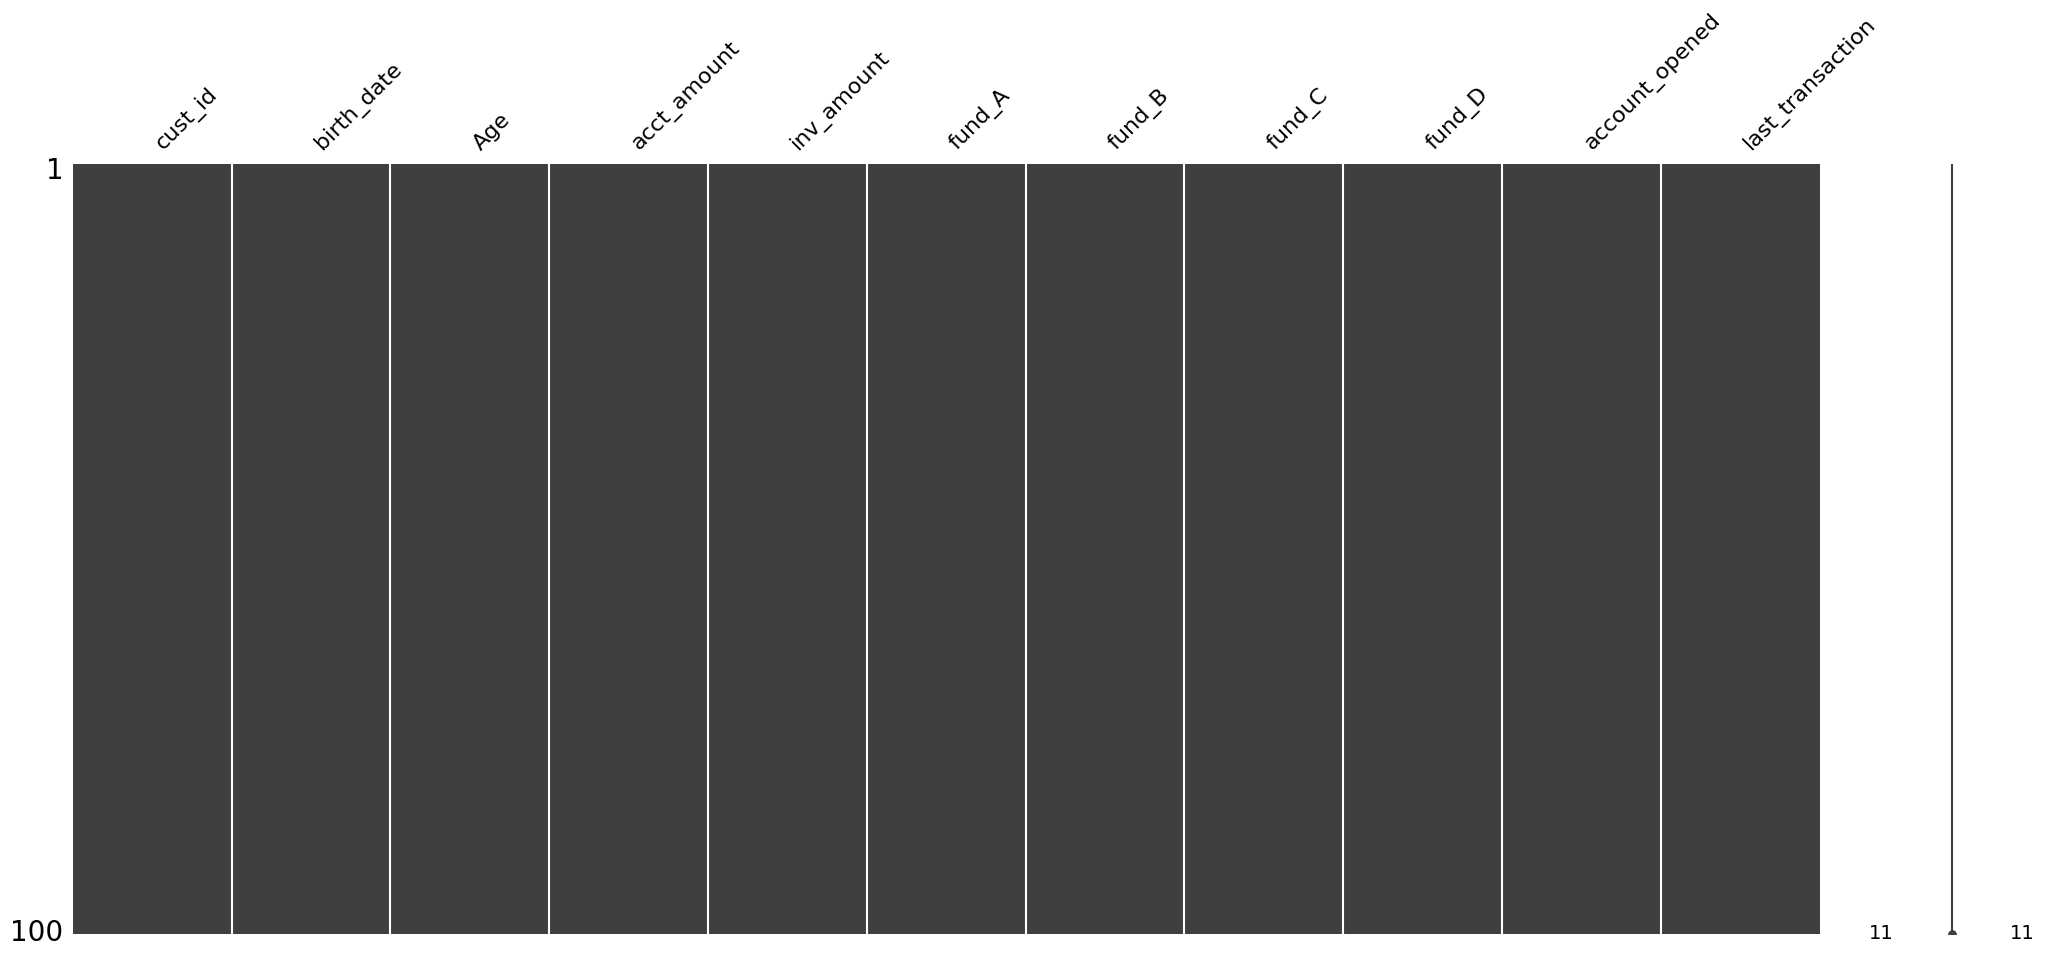

In [24]:
# Print number of missing values in banking
bank_na = banking.copy()

# Set to exercise nulls for single column
bank_na.loc[bank_na.index.isin([4, 14, 17, 18, 35, 40, 46, 54, 59, 82, 88, 93, 94]), 'inv_amount'] = np.nan

# validate null values
print(bank_na.isna().sum(), '\n')

# Visualize missingness matrix
msno.matrix(banking)
plt.show()

In [25]:
# Look at null rows for inv_amount
display(bank_na.loc[bank_na['inv_amount'].isna(), :])

,cust_id,birth_date,Age,acct_amount,inv_amount,fund_A,fund_B,fund_C,fund_D,account_opened,last_transaction
4,7A73F334,1990-05-17,30,120512.00,NaN,12158.4,51281.0,13434.0,18383.0,14-05-18,19-07-18
14,987DC93E,1978-03-13,42,35924.41,NaN,182.0,5064.0,3028.0,6606.0,30-12-18,06-12-18
17,984403B9,1983-01-30,37,17939.88,NaN,6286.0,1050.0,3690.0,3401.0,07-10-17,18-05-18
18,C9FB0E86,1965-10-04,55,88682.34,NaN,5504.0,4063.0,5602.0,10995.0,19-05-18,06-08-19
35,078C654F,1993-10-17,27,87312.64,NaN,3684.0,17635.0,11717.0,33493.0,14-04-17,05-08-18
40,777A7F2C,1973-08-12,47,52684.17,NaN,380.0,2402.0,14612.0,3574.0,27-10-18,25-05-19
46,ACE5C956,1989-12-26,31,90413.25,NaN,6087.0,4387.0,879.0,10219.0,29-12-18,30-04-19
54,2F4F99C1,1988-12-19,36,82058.48,NaN,6129.0,16840.0,10397.0,2392.0,30-12-18,11-08-18
59,3B240FEF,1968-03-30,52,97856.46,NaN,13521.0,13303.0,8336.0,29678.0,23-05-18,11-10-18
82,19C86773,1973-02-23,47,63182.57,NaN,16863.0,12793.0,12612.0,20423.0,09-05-18,26-01-20


In [26]:
# Isolate missing and non missing values of inv_amount
missing_investors = bank_na.loc[bank_na['inv_amount'].isna(), :]
investors = bank_na.loc[~bank_na['inv_amount'].isna(), :]
print(len(bank_na), len(missing_investors), len(investors))
assert len(bank_na) == (len(missing_investors) + len(investors))

100 13 87


### Follow the money
In this exercise, you're working with another version of the banking DataFrame that contains missing values for both the cust_id column and the acct_amount column.

You want to produce analysis on how many unique customers the bank has, the average amount held by customers and more. You know that rows with missing cust_id don't really help you, and that on average acct_amount is usually 5 times the amount of inv_amount.

In this exercise, you will drop rows of banking with missing cust_ids, and impute missing values of acct_amount with some domain knowledge.

```python
In [1]:
banking.isna().sum()
Out[1]:

cust_id              9
acct_amount         14
inv_amount           0
account_opened       0
last_transaction     0
dtype: int64

# Drop missing values of cust_id
banking_fullid = banking.dropna(subset = ['cust_id'])

# Compute estimated acct_amount
acct_imp = banking_fullid['inv_amount'] * 5

# Impute missing acct_amount with corresponding acct_imp
banking_imputed = banking_fullid.fillna({'acct_amount':acct_imp})

# Print number of missing values
print(banking_imputed.isna().sum())

cust_id             0
acct_amount         0
inv_amount          0
account_opened      0
last_transaction    0
dtype: int64


In [10]:
banking_fullid.head(10)
Out[10]:

    cust_id  acct_amount  inv_amount account_opened last_transaction
0  8C35540A     44244.71    35500.50       03-05-18         30-09-19
1  D5536652          NaN    81921.86       21-01-18         14-01-19
2  A631984D          NaN    46412.27       26-01-18         06-10-19
3  93F2F951          NaN    76563.35       21-08-17         10-07-19
4  DE0A0882          NaN    18669.01       05-06-17         15-01-19
5  25E68E1B    109737.62    93552.69       26-12-17         12-11-18
6  3FA9296D          NaN    70357.70       21-06-18         24-08-18
7  984403B9          NaN    14429.59       07-10-17         18-05-18
8  870A9281     63523.31    51297.32       02-09-18         22-02-19
9  166B05B0     38175.46    15052.70       28-02-19         31-10-18

In [12]:
acct_imp.head(10)
Out[12]:

0    177502.50
1    409609.30
2    232061.35
3    382816.75
4     93345.05
5    467763.45
6    351788.50
7     72147.95
8    256486.60
9     75263.50

In [11]:
banking_imputed.head(10)
Out[11]:

    cust_id  acct_amount  inv_amount account_opened last_transaction
0  8C35540A     44244.71    35500.50       03-05-18         30-09-19
1  D5536652    409609.30    81921.86       21-01-18         14-01-19
2  A631984D    232061.35    46412.27       26-01-18         06-10-19
3  93F2F951    382816.75    76563.35       21-08-17         10-07-19
4  DE0A0882     93345.05    18669.01       05-06-17         15-01-19
5  25E68E1B    109737.62    93552.69       26-12-17         12-11-18
6  3FA9296D    351788.50    70357.70       21-06-18         24-08-18
7  984403B9     72147.95    14429.59       07-10-17         18-05-18
8  870A9281     63523.31    51297.32       02-09-18         22-02-19
9  166B05B0     38175.46    15052.70       28-02-19         31-10-18
```
* `banking_fullid` drop all dataframe values for a found null value for `cust_id`
* `acct_imp` is a pandas series holding the inv_amount field times 5 for each row in the dataframe without null values for customer id
* `banking_imputed` then fills the null values for empty `acct_amount` values with the created series only filling in nulls for the column and discarding the values for rows where a previous `acct_amount` value was null

### Record Linkage
Record linkage is a powerful technique used to merge multiple datasets together, used when values have typos or different spellings. In this chapter, you'll learn how to link records by calculating the similarity between strings—you’ll then use your new skills to join two restaurant review datasets into one clean master dataset.

In this exercise, and throughout this chapter, you'll be working with the restaurants DataFrame which has data on various restaurants. Your ultimate goal is to create a restaurant recommendation engine, but you need to first clean your data.

This version of restaurants has been collected from many sources, where the cuisine_type column is riddled with typos, and should contain only italian, american and asian cuisine types. There are so many unique categories that remapping them manually isn't scalable, and it's best to use string similarity instead.

Before doing so, you want to establish the cutoff point for the similarity score using the thefuzz's process.extract() function by finding the similarity score of the most distant typo of each category.

```python
# Import process from thefuzz
from thefuzz import process

# Store the unique values of cuisine_type in unique_types
unique_types = restaurants['cuisine_type'].unique()

# Calculate similarity of 'asian' to all values of unique_types
print(process.extract('asian', unique_types, limit = len(unique_types)))

# Calculate similarity of 'american' to all values of unique_types
print(process.extract('american', unique_types, limit = len(unique_types)))

# Calculate similarity of 'italian' to all values of unique_types
print(process.extract('italian', unique_types, limit = len(unique_types)))

# first output
[('asian', 100), ('asiane', 91), ('asiann', 91), ('asiian', 91), ('asiaan', 91), ('asianne', 83), ('asiat', 80), ('italiann', 72), ('italiano', 72), ('italianne', 72), ('italian', 67), ('amurican', 62), ('american', 62), ('italiaan', 62), ('italiian', 62), ('itallian', 62), ('americann', 57), ('americano', 57), ('ameerican', 57), ('aamerican', 57), ('ameriican', 57), ('amerrican', 57), ('ammericann', 54), ('ameerrican', 54), ('ammereican', 54), ('america', 50), ('merican', 50), ('murican', 50), ('italien', 50), ('americen', 46), ('americin', 46), ('amerycan', 46), ('itali', 40)]

# second output
[('american', 100), ('americann', 94), ('americano', 94), ('ameerican', 94), ('aamerican', 94), ('ameriican', 94), ('amerrican', 94), ('america', 93), ('merican', 93), ('ammericann', 89), ('ameerrican', 89), ('ammereican', 89), ('amurican', 88), ('americen', 88), ('americin', 88), ('amerycan', 88), ('murican', 80), ('asian', 62), ('asiane', 57), ('asiann', 57), ('asiian', 57), ('asiaan', 57), ('italian', 53), ('asianne', 53), ('italiann', 50), ('italiano', 50), ('italiaan', 50), ('italiian', 50), ('itallian', 50), ('italianne', 47), ('asiat', 46), ('itali', 40), ('italien', 40)]

# third output
[('italian', 100), ('italiann', 93), ('italiano', 93), ('italiaan', 93), ('italiian', 93), ('itallian', 93), ('italianne', 88), ('italien', 86), ('itali', 83), ('asian', 67), ('asiane', 62), ('asiann', 62), ('asiian', 62), ('asiaan', 62), ('asianne', 57), ('amurican', 53), ('american', 53), ('americann', 50), ('asiat', 50), ('americano', 50), ('ameerican', 50), ('aamerican', 50), ('ameriican', 50), ('amerrican', 50), ('ammericann', 47), ('ameerrican', 47), ('ammereican', 47), ('america', 43), ('merican', 43), ('murican', 43), ('americen', 40), ('americin', 40), ('amerycan', 40)]
```

### Remapping categories II
In the last exercise, you determined that the distance cutoff point for remapping typos of 'american', 'asian', and 'italian' cuisine types stored in the cuisine_type column should be 80.

In this exercise, you're going to put it all together by finding matches with similarity scores equal to or higher than 80 by using fuzywuzzy.process's extract() function, for each correct cuisine type, and replacing these matches with it. Remember, when comparing a string with an array of strings using process.extract(), the output is a list of tuples where each is formatted like:

(closest match, similarity score, index of match)

The restaurants DataFrame is in your environment, and you have access to a categories list containing the correct cuisine types ('italian', 'asian', and 'american').

```python
# Iterate through categories : ['italian', 'asian', 'american']
for cuisine in categories:  
  # Create a list of matches, comparing cuisine with the cuisine_type column
  matches = process.extract(cuisine, restaurants['cuisine_type'], limit=len(restaurants.cuisine_type))
  print(matches[:2], matches[-3:])
  # Iterate through the list of matches
  for match in matches:
     # Check whether the similarity score is greater than or equal to 80
    if match[1] >= 80:
      # If it is, select all rows where the cuisine_type is spelled this way, and set them to the correct cuisine
      restaurants.loc[restaurants['cuisine_type'] == match[0]] = cuisine
      
# Inspect the final result
print(restaurants['cuisine_type'].unique())

# Sample matches tuples iterated through for each category that is evaluated in nested loop
<script.py> output:
    [('italian', 100, 11), ('italian', 100, 25)] [('americen', 40, 3), ('americin', 40, 20), ('amerycan', 40, 23)]
    [('asian', 100, 38), ('asian', 100, 46)] [('americen', 46, 3), ('americin', 46, 20), ('amerycan', 46, 23)]
    [('american', 100, 13), ('american', 100, 36)] [('italian', 53, 325), ('italian', 53, 331), ('italian', 53, 332)]
    
    ['american' 'asian' 'italian']
```
* Notice how each value in the entire original dataframe column (pandas series) is evaluated and scored based on the categories
* Should a row value for an extraction score meet a threshold for the category, we change the value of the column to the defined category to link like values in a pandas series


### Generating Pairs
Pairs of restaurants
In the last lesson, you cleaned the restaurants dataset to make it ready for building a restaurants recommendation engine. You have a new DataFrame named restaurants_new with new restaurants to train your model on, that's been scraped from a new data source.

You've already cleaned the cuisine_type and city columns using the techniques learned throughout the course. However you saw duplicates with typos in restaurants names that require record linkage instead of joins with restaurants.

In this exercise, you will perform the first step in record linkage and generate possible pairs of rows between restaurants and restaurants_new. Both DataFrames, pandas and recordlinkage are in your environment.

```python
n [2]:
restaurants_new.head()
Out[2]:

  rest_name                 rest_addr         city       phone  cuisine_type
0    kokomo         6333 w. third st.           la  2139330773      american
1    feenix   8358 sunset blvd. west     hollywood  2138486677      american
2   parkway      510 s. arroyo pkwy .     pasadena  8187951001   californian
3      r-23          923 e. third st.  los angeles  2136877178      japanese
4     gumbo         6333 w. third st.           la  2139330358  cajun/creole
In [3]:
restaurants.head()
Out[3]:

                   rest_name                  rest_addr         city       phone cuisine_type
0  arnie morton's of chicago   435 s. la cienega blv .   los angeles  3102461501     american
1         art's delicatessen       12224 ventura blvd.   studio city  8187621221     american
2                  campanile       624 s. la brea ave.   los angeles  2139381447     american
3                      fenix    8358 sunset blvd. west     hollywood  2138486677     american
4         grill on the alley           9560 dayton way   los angeles  3102760615     american

# Table outputs above for genearting pairs using recordlinkage and shared cusine_type
# Create an indexer and object and find possible pairs
indexer = recordlinkage.Index()

# Block pairing on cuisine_type
indexer.block('cuisine_type')

# Generate pairs
pairs = indexer.index(restaurants, restaurants_new)
```

### Similar restaurants
In the last exercise, you generated pairs between restaurants and restaurants_new in an effort to cleanly merge both DataFrames using record linkage.

When performing record linkage, there are different types of matching you can perform between different columns of your DataFrames, including exact matches, string similarities, and more.

Now that your pairs have been generated and stored in pairs, you will find exact matches in the city and cuisine_type columns between each pair, and similar strings for each pair in the rest_name column. Both DataFrames, pandas and recordlinkage are in your environment.

```python
# Create a comparison object
comp_cl = recordlinkage.Compare()

# Find exact matches on city, cuisine_types - 
comp_cl.exact('city', 'city', label='city')
comp_cl.exact('cuisine_type', 'cuisine_type', label='cuisine_type')

# Find similar matches of rest_name
comp_cl.string('rest_name', 'rest_name', label='name', threshold = 0.8) 

# Get potential matches and print
potential_matches = comp_cl.compute(pairs, restaurants, restaurants_new)
print(potential_matches)


script.py

# Create a comparison object
comp_cl = recordlinkage.Compare()

# Find exact matches on city, cuisine_types - 
comp_cl.exact('city', 'city', label='city')
comp_cl.exact('cuisine_type', 'cuisine_type', label='cuisine_type')

# Find similar matches of rest_name
comp_cl.string('rest_name', 'rest_name', label='name', threshold = 0.8) 

# Get potential matches and print
potential_matches = comp_cl.compute(pairs, restaurants, restaurants_new)
print(potential_matches)

cust_id              object
age                   int64
acct_amount         float64
inv_amount          float64
account_opened       object
last_transaction     object
dtype: object

cust_id              0
age                  0
acct_amount          0
inv_amount          13
account_opened       0
last_transaction     0
dtype: int64

     cust_id  age  acct_amount  inv_amount account_opened last_transaction
4   DE0A0882   21     99998.35         NaN       05-06-17         15-01-19
14  E7389E60   22     86028.48         NaN       04-06-17         07-08-18
17  D3287768   20     89961.77         NaN       03-09-18         19-10-18
18  FA01676F   21     66947.30         NaN       10-08-18         23-07-19
35  904A19DD   20     31981.36         NaN       28-01-19         23-06-19
40  93E78DA3   22     41942.23         NaN       09-10-17         15-04-18
46  3B240FEF   25     97856.46         NaN       23-05-18         11-10-18
54  6B094617   21     89855.98         NaN       06-02-18         14-02-19
59  56D310A8   21     88660.40         NaN       25-02-18         29-07-18
82  078C654F   21     87312.64         NaN       14-04-17         05-08-18
88  33CA2B76   23     75508.61         NaN       16-11-17         03-03-19
93  4C7F8638   23     21942.37         NaN       14-07-18         02-02-19
94  A81D31B3   24     74010.15         NaN       02-06-18         12-09-18
# Print number of missing values in banking
print(banking.isna().sum())

# Visualize missingness matrix
msno.matrix(banking)
plt.show()

# Isolate missing and non missing values of inv_amount
missing_investors = bank_na.loc[bank_na['inv_amount'].isna(), :]
investors = bank_na.loc[~bank_na['inv_amount'].isna(), :]
cust_id              0
age                  0
acct_amount          0
inv_amount          13
account_opened       0
last_transaction     0
dtype: int64

# Print number of missing values in banking
print(banking.isna().sum())

# Visualize missingness matrix
msno.matrix(banking)
plt.show()

# Isolate missing and non missing values of inv_amount
missing_investors = banking.loc[banking['inv_amount'].isna(), :]
investors = banking.loc[~banking['inv_amount'].isna(), :]
cust_id              0
age                  0
acct_amount          0
inv_amount          13
account_opened       0
last_transaction     0
dtype: int64

<script.py> output:
    cust_id              0
    age                  0
    acct_amount          0
    inv_amount          13
    account_opened       0
    last_transaction     0
    dtype: int64

<script.py> output:
    cust_id              0
    age                  0
    acct_amount          0
    inv_amount          13
    account_opened       0
    last_transaction     0
    dtype: int64

          age  acct_amount  inv_amount
count  84.000       84.000      84.000
mean   43.560    75095.273   44717.885
std    10.411    32414.506   26031.246
min    26.000    12209.840    3216.720
25%    34.000    57373.062   22736.037
50%    45.000    83061.845   44498.460
75%    53.000    94165.965   66176.803
max    59.000   250046.760   93552.690

          age  acct_amount  inv_amount
count  13.000       13.000         0.0
mean   21.846    73231.238         NaN
std     1.519    25553.327         NaN
min    20.000    21942.370         NaN
25%    21.000    66947.300         NaN
50%    21.000    86028.480         NaN
75%    23.000    89855.980         NaN
max    25.000    99998.350         NaN
# Print number of missing values in banking
print(banking.isna().sum())

# Visualize missingness matrix
msno.matrix(banking)
plt.show()

# Isolate missing and non missing values of inv_amount
missing_investors = banking[banking['inv_amount'].isna()]
investors = banking[~banking['inv_amount'].isna()]

# Sort banking by age and visualize
banking_sorted = banking.sort_values('age')
msno.matrix(banking_sorted)
plt.show()
cust_id              0
age                  0
acct_amount          0
inv_amount          13
account_opened       0
last_transaction     0
dtype: int64

<script.py> output:
    cust_id              0
    age                  0
    acct_amount          0
    inv_amount          13
    account_opened       0
    last_transaction     0
    dtype: int64
# Print number of missing values in banking
print(banking.isna().sum())

# Visualize missingness matrix
msno.matrix(banking)
plt.show()

# Isolate missing and non missing values of inv_amount
missing_investors = banking[banking['inv_amount'].isna()]
investors = banking[~banking['inv_amount'].isna()]

# Sort banking by age and visualize
banking_sorted = banking.sort_values('age')
msno.matrix(banking_sorted)
plt.show()

cust_id              9
acct_amount         14
inv_amount           0
account_opened       0
last_transaction     0
dtype: int64

cust_id              0
acct_amount         14
inv_amount           0
account_opened       0
last_transaction     0
dtype: int64

0     177502.50
1     409609.30
2     232061.35
3     382816.75
4      93345.05
        ...    
91    156975.00
92    389484.30
93     58576.20
94    243937.35
95     46939.35
Name: inv_amount, Length: 88, dtype: float64

     cust_id  acct_amount  inv_amount account_opened last_transaction
0   8C35540A     44244.71    35500.50       03-05-18         30-09-19
1   D5536652          NaN    81921.86       21-01-18         14-01-19
2   A631984D          NaN    46412.27       26-01-18         06-10-19
3   93F2F951          NaN    76563.35       21-08-17         10-07-19
4   DE0A0882          NaN    18669.01       05-06-17         15-01-19
5   25E68E1B    109737.62    93552.69       26-12-17         12-11-18
6   3FA9296D          NaN    70357.70       21-06-18         24-08-18
7   984403B9          NaN    14429.59       07-10-17         18-05-18
8   870A9281     63523.31    51297.32       02-09-18         22-02-19
9   166B05B0     38175.46    15052.70       28-02-19         31-10-18
10  0A9BA907     90469.53    70173.49       15-06-18         28-08-18
11  2AB6539A     53796.13    12401.32       03-01-19         17-11-18
12  F389832C          NaN    58388.14       03-02-18         23-09-18
15  CA507BA1     12209.84     7516.33       26-05-18         11-09-19
16  472341F2     83127.65    67961.74       14-12-18         22-04-18
17  D3287768     89961.77    84216.09       03-09-18         19-10-18
18  FA01676F     66947.30    52551.65       10-08-18         23-07-19
19  A69FA1B8     75207.99    31620.86       23-02-19         09-09-19
20  9B550FD5     32891.31    11993.35       02-05-18         27-06-19
21  B99CD662     92838.44    49090.83       04-05-17         12-03-19
22  7A73F334    120512.00    93233.00       14-05-18         19-07-18
23  B40E8497     99771.90    86992.74       16-05-17         05-01-20
26  EC189A55     83343.18     7282.91       04-02-19         31-12-18
27  3C5CBBD7     59678.01    35939.08       03-01-19         02-10-18
28  F7FC8F78          NaN    84432.03       28-02-18         30-04-18
# Drop missing values of cust_id
banking_fullid = banking.dropna(subset = ['cust_id'])

# Compute estimated acct_amount
acct_imp = banking_fullid['inv_amount'] * 5

# Impute missing acct_amount with corresponding acct_imp
banking_imputed = banking_fullid.fillna({'acct_amount':acct_imp})

# Print number of missing values
print(banking_imputed.isna().sum())
cust_id             0
acct_amount         0
inv_amount          0
account_opened      0
last_transaction    0
dtype: int64

    cust_id  acct_amount  inv_amount account_opened last_transaction
0  8C35540A     44244.71    35500.50       03-05-18         30-09-19
1  D5536652    409609.30    81921.86       21-01-18         14-01-19
2  A631984D    232061.35    46412.27       26-01-18         06-10-19
3  93F2F951    382816.75    76563.35       21-08-17         10-07-19
4  DE0A0882     93345.05    18669.01       05-06-17         15-01-19

    cust_id  acct_amount  inv_amount account_opened last_transaction
0  8C35540A     44244.71    35500.50       03-05-18         30-09-19
1  D5536652          NaN    81921.86       21-01-18         14-01-19
2  A631984D          NaN    46412.27       26-01-18         06-10-19
3  93F2F951          NaN    76563.35       21-08-17         10-07-19
4  DE0A0882          NaN    18669.01       05-06-17         15-01-19

0    177502.50
1    409609.30
2    232061.35
3    382816.75
4     93345.05
Name: inv_amount, dtype: float64

0    177502.50
1    409609.30
2    232061.35
3    382816.75
4     93345.05
5    467763.45
6    351788.50
7     72147.95
8    256486.60
9     75263.50
Name: inv_amount, dtype: float64

    cust_id  acct_amount  inv_amount account_opened last_transaction
0  8C35540A     44244.71    35500.50       03-05-18         30-09-19
1  D5536652          NaN    81921.86       21-01-18         14-01-19
2  A631984D          NaN    46412.27       26-01-18         06-10-19
3  93F2F951          NaN    76563.35       21-08-17         10-07-19
4  DE0A0882          NaN    18669.01       05-06-17         15-01-19
5  25E68E1B    109737.62    93552.69       26-12-17         12-11-18
6  3FA9296D          NaN    70357.70       21-06-18         24-08-18
7  984403B9          NaN    14429.59       07-10-17         18-05-18
8  870A9281     63523.31    51297.32       02-09-18         22-02-19
9  166B05B0     38175.46    15052.70       28-02-19         31-10-18

    cust_id  acct_amount  inv_amount account_opened last_transaction
0  8C35540A     44244.71    35500.50       03-05-18         30-09-19
1  D5536652    409609.30    81921.86       21-01-18         14-01-19
2  A631984D    232061.35    46412.27       26-01-18         06-10-19
3  93F2F951    382816.75    76563.35       21-08-17         10-07-19
4  DE0A0882     93345.05    18669.01       05-06-17         15-01-19
5  25E68E1B    109737.62    93552.69       26-12-17         12-11-18
6  3FA9296D    351788.50    70357.70       21-06-18         24-08-18
7  984403B9     72147.95    14429.59       07-10-17         18-05-18
8  870A9281     63523.31    51297.32       02-09-18         22-02-19
9  166B05B0     38175.46    15052.70       28-02-19         31-10-18

0    177502.50
1    409609.30
2    232061.35
3    382816.75
4     93345.05
5    467763.45
6    351788.50
7     72147.95
8    256486.60
9     75263.50
Name: inv_amount, dtype: float64

<script.py> output:
    cust_id             0
    acct_amount         0
    inv_amount          0
    account_opened      0
    last_transaction    0
    dtype: int64
# Drop missing values of cust_id
banking_fullid = banking.dropna(subset = ['cust_id'])

# Compute estimated acct_amount
acct_imp = banking_fullid['inv_amount'] * 5

# Impute missing acct_amount with corresponding acct_imp
banking_imputed = banking_fullid.fillna({'acct_amount':acct_imp})

# Print number of missing values
print(banking_imputed.isna().sum())
<class 'pandas.core.frame.DataFrame'>
Int64Index: 287 entries, 0 to 335
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   rest_name     287 non-null    object
 1   rest_addr     287 non-null    object
 2   city          287 non-null    object
 3   phone         287 non-null    int64 
 4   cuisine_type  287 non-null    object
dtypes: int64(1), object(4)
memory usage: 13.5+ KB

american      116
italian        69
asian          65
americann       4
italiaan        3
asianne         2
ameerican       2
aamerican       1
ameriican       1
asiian          1
asiaan          1
ammericann      1
amerrican       1
ameerrican      1
ammereican      1
italianne       1
italiian        1
amerycan        1
america         1
americin        1
italiano        1
merican         1
italiann        1
americano       1
asiat           1
italien         1
murican         1
asiann          1
itali           1
asiane          1
americen        1
amurican        1
itallian        1
Name: cuisine_type, dtype: int64
# Import process from thefuzz
from thefuzz import process

# Store the unique values of cuisine_type in unique_types
unique_types = restaurants['cuisine_type'].unique()

# Calculate similarity of 'asian' to all values of unique_types
print(process.extract('asian', unique_types, limit = len(unique_types)))

# Calculate similarity of 'american' to all values of unique_types
print(process.extract('american', unique_types, limit = len(unique_types)))

# Calculate similarity of 'italian' to all values of unique_types
print(process.extract('italian', unique_types, limit = len(unique_types)))
[('asian', 100), ('asiane', 91), ('asiann', 91), ('asiian', 91), ('asiaan', 91), ('asianne', 83), ('asiat', 80), ('italiann', 72), ('italiano', 72), ('italianne', 72), ('italian', 67), ('amurican', 62), ('american', 62), ('italiaan', 62), ('italiian', 62), ('itallian', 62), ('americann', 57), ('americano', 57), ('ameerican', 57), ('aamerican', 57), ('ameriican', 57), ('amerrican', 57), ('ammericann', 54), ('ameerrican', 54), ('ammereican', 54), ('america', 50), ('merican', 50), ('murican', 50), ('italien', 50), ('americen', 46), ('americin', 46), ('amerycan', 46), ('itali', 40)]
[('american', 100), ('americann', 94), ('americano', 94), ('ameerican', 94), ('aamerican', 94), ('ameriican', 94), ('amerrican', 94), ('america', 93), ('merican', 93), ('ammericann', 89), ('ameerrican', 89), ('ammereican', 89), ('amurican', 88), ('americen', 88), ('americin', 88), ('amerycan', 88), ('murican', 80), ('asian', 62), ('asiane', 57), ('asiann', 57), ('asiian', 57), ('asiaan', 57), ('italian', 53), ('asianne', 53), ('italiann', 50), ('italiano', 50), ('italiaan', 50), ('italiian', 50), ('itallian', 50), ('italianne', 47), ('asiat', 46), ('itali', 40), ('italien', 40)]
[('italian', 100), ('italiann', 93), ('italiano', 93), ('italiaan', 93), ('italiian', 93), ('itallian', 93), ('italianne', 88), ('italien', 86), ('itali', 83), ('asian', 67), ('asiane', 62), ('asiann', 62), ('asiian', 62), ('asiaan', 62), ('asianne', 57), ('amurican', 53), ('american', 53), ('americann', 50), ('asiat', 50), ('americano', 50), ('ameerican', 50), ('aamerican', 50), ('ameriican', 50), ('amerrican', 50), ('ammericann', 47), ('ameerrican', 47), ('ammereican', 47), ('america', 43), ('merican', 43), ('murican', 43), ('americen', 40), ('americin', 40), ('amerycan', 40)]

<script.py> output:
    [('asian', 100), ('asiane', 91), ('asiann', 91), ('asiian', 91), ('asiaan', 91), ('asianne', 83), ('asiat', 80), ('italiann', 72), ('italiano', 72), ('italianne', 72), ('italian', 67), ('amurican', 62), ('american', 62), ('italiaan', 62), ('italiian', 62), ('itallian', 62), ('americann', 57), ('americano', 57), ('ameerican', 57), ('aamerican', 57), ('ameriican', 57), ('amerrican', 57), ('ammericann', 54), ('ameerrican', 54), ('ammereican', 54), ('america', 50), ('merican', 50), ('murican', 50), ('italien', 50), ('americen', 46), ('americin', 46), ('amerycan', 46), ('itali', 40)]
    [('american', 100), ('americann', 94), ('americano', 94), ('ameerican', 94), ('aamerican', 94), ('ameriican', 94), ('amerrican', 94), ('america', 93), ('merican', 93), ('ammericann', 89), ('ameerrican', 89), ('ammereican', 89), ('amurican', 88), ('americen', 88), ('americin', 88), ('amerycan', 88), ('murican', 80), ('asian', 62), ('asiane', 57), ('asiann', 57), ('asiian', 57), ('asiaan', 57), ('italian', 53), ('asianne', 53), ('italiann', 50), ('italiano', 50), ('italiaan', 50), ('italiian', 50), ('itallian', 50), ('italianne', 47), ('asiat', 46), ('itali', 40), ('italien', 40)]
    [('italian', 100), ('italiann', 93), ('italiano', 93), ('italiaan', 93), ('italiian', 93), ('itallian', 93), ('italianne', 88), ('italien', 86), ('itali', 83), ('asian', 67), ('asiane', 62), ('asiann', 62), ('asiian', 62), ('asiaan', 62), ('asianne', 57), ('amurican', 53), ('american', 53), ('americann', 50), ('asiat', 50), ('americano', 50), ('ameerican', 50), ('aamerican', 50), ('ameriican', 50), ('amerrican', 50), ('ammericann', 47), ('ameerrican', 47), ('ammereican', 47), ('america', 43), ('merican', 43), ('murican', 43), ('americen', 40), ('americin', 40), ('amerycan', 40)]
# Import process from thefuzz
from thefuzz import process

# Store the unique values of cuisine_type in unique_types
unique_types = restaurants['cuisine_type'].unique()

# Calculate similarity of 'asian' to all values of unique_types
print(process.extract('asian', unique_types, limit = len(unique_types)))

# Calculate similarity of 'american' to all values of unique_types
print(process.extract('american', unique_types, limit = len(unique_types)))

# Calculate similarity of 'italian' to all values of unique_types
print(process.extract('italian', unique_types, limit = len(unique_types)))
# Inspect the unique values of the cuisine_type column
print(restaurants['cuisine_type'].unique())
['america' 'merican' 'amurican' 'americen' 'americann' 'asiane' 'itali'
 'asiann' 'murican' 'italien' 'italian' 'asiat' 'american' 'americano'
 'italiann' 'ameerican' 'asianne' 'italiano' 'americin' 'ammericann'
 'amerycan' 'aamerican' 'ameriican' 'italiaan' 'asiian' 'asiaan'
 'amerrican' 'ameerrican' 'ammereican' 'asian' 'italianne' 'italiian'
 'itallian']

<script.py> output:
    ['america' 'merican' 'amurican' 'americen' 'americann' 'asiane' 'itali'
     'asiann' 'murican' 'italien' 'italian' 'asiat' 'american' 'americano'
     'italiann' 'ameerican' 'asianne' 'italiano' 'americin' 'ammericann'
     'amerycan' 'aamerican' 'ameriican' 'italiaan' 'asiian' 'asiaan'
     'amerrican' 'ameerrican' 'ammereican' 'asian' 'italianne' 'italiian'
     'itallian']
# Create a list of matches, comparing 'italian' with the cuisine_type column
matches = process.extract('italian', restaurants['cuisine_type'].unique())

# Inspect the first 5 matches
print(matches[0:5])
[('italian', 100), ('italiann', 93), ('italiano', 93), ('italiaan', 93), ('italiian', 93)]
# Create a list of matches, comparing 'italian' with the cuisine_type column
matches = process.extract('italian', restaurants['cuisine_type'].unique())

# Inspect the first 5 matches
print(matches[0:5], len(matches))
[('italian', 100), ('italiann', 93), ('italiano', 93), ('italiaan', 93), ('italiian', 93)] 5
# Create a list of matches, comparing 'italian' with the cuisine_type column
matches = process.extract('italian', restaurants['cuisine_type'].unique())

# Inspect the first 5 matches
print(matches[0:5])
print(matches)
[('italian', 100), ('italiann', 93), ('italiano', 93), ('italiaan', 93), ('italiian', 93)]
[('italian', 100), ('italiann', 93), ('italiano', 93), ('italiaan', 93), ('italiian', 93)]

<script.py> output:
    [('italian', 100), ('italiann', 93), ('italiano', 93), ('italiaan', 93), ('italiian', 93)]
    [('italian', 100), ('italiann', 93), ('italiano', 93), ('italiaan', 93), ('italiian', 93)]
# Create a list of matches, comparing 'italian' with the cuisine_type column
matches = process.extract('italian', restaurants['cuisine_type'].unique(), 
limit=len(restaurants['cuisine_type'].unique()))

# Inspect the first 5 matches
print(matches[0:5])
print(matches)
[('italian', 100), ('italiann', 93), ('italiano', 93), ('italiaan', 93), ('italiian', 93)]
[('italian', 100), ('italiann', 93), ('italiano', 93), ('italiaan', 93), ('italiian', 93), ('itallian', 93), ('italianne', 88), ('italien', 86), ('itali', 83), ('asian', 67), ('asiane', 62), ('asiann', 62), ('asiian', 62), ('asiaan', 62), ('asianne', 57), ('amurican', 53), ('american', 53), ('americann', 50), ('asiat', 50), ('americano', 50), ('ameerican', 50), ('aamerican', 50), ('ameriican', 50), ('amerrican', 50), ('ammericann', 47), ('ameerrican', 47), ('ammereican', 47), ('america', 43), ('merican', 43), ('murican', 43), ('americen', 40), ('americin', 40), ('amerycan', 40)]

<script.py> output:
    [('italian', 100), ('italiann', 93), ('italiano', 93), ('italiaan', 93), ('italiian', 93)]
    [('italian', 100), ('italiann', 93), ('italiano', 93), ('italiaan', 93), ('italiian', 93), ('itallian', 93), ('italianne', 88), ('italien', 86), ('itali', 83), ('asian', 67), ('asiane', 62), ('asiann', 62), ('asiian', 62), ('asiaan', 62), ('asianne', 57), ('amurican', 53), ('american', 53), ('americann', 50), ('asiat', 50), ('americano', 50), ('ameerican', 50), ('aamerican', 50), ('ameriican', 50), ('amerrican', 50), ('ammericann', 47), ('ameerrican', 47), ('ammereican', 47), ('america', 43), ('merican', 43), ('murican', 43), ('americen', 40), ('americin', 40), ('amerycan', 40)]
# Create a list of matches, comparing 'italian' with the cuisine_type column
matches = process.extract('italian', restaurants['cuisine_type'], limit=len(restaurants.cuisine_type))

# Inspect the first 5 matches
print(matches[0:5])
[('italian', 100, 11), ('italian', 100, 25), ('italian', 100, 41), ('italian', 100, 47), ('italian', 100, 49)]
# Create a list of matches, comparing 'italian' with the cuisine_type column
matches = process.extract('italian', restaurants['cuisine_type'], limit=len(restaurants.cuisine_type))

# Inspect the first 5 matches
print(matches[0:5], len(restaurants.cuisine_type))
[('italian', 100, 11), ('italian', 100, 25), ('italian', 100, 41), ('italian', 100, 47), ('italian', 100, 49)] 287

<script.py> output:
    [('italian', 100, 11), ('italian', 100, 25), ('italian', 100, 41), ('italian', 100, 47), ('italian', 100, 49)] 287


# Iterate through categories : ['italian', 'asian', 'american']
for cuisine in categories:  
  # Create a list of matches, comparing cuisine with the cuisine_type column
  matches = process.extract(cuisine, restaurants['cuisine_type'], limit=len(restaurants.cuisine_type))
  print(matches[:5])
  # Iterate through the list of matches
  for match in matches:
     # Check whether the similarity score is greater than or equal to 80
    if match[1] >= 80:
      # If it is, select all rows where the cuisine_type is spelled this way, and set them to the correct cuisine
      restaurants.loc[restaurants['cuisine_type'] == match[0]] = cuisine
      
# Inspect the final result
print(restaurants['cuisine_type'].unique())
[('italian', 100, 11), ('italian', 100, 25), ('italian', 100, 41), ('italian', 100, 47), ('italian', 100, 49)]
[('asian', 100, 38), ('asian', 100, 46), ('asian', 100, 53), ('asian', 100, 54), ('asian', 100, 67)]
[('american', 100, 13), ('american', 100, 36), ('american', 100, 37), ('american', 100, 42), ('american', 100, 43)]
['american' 'asian' 'italian']
# Iterate through categories : ['italian', 'asian', 'american']
for cuisine in categories:  
  # Create a list of matches, comparing cuisine with the cuisine_type column
  matches = process.extract(cuisine, restaurants['cuisine_type'], limit=len(restaurants.cuisine_type))
  print(matches[:2], matches[-3:])
  # Iterate through the list of matches
  for match in matches:
     # Check whether the similarity score is greater than or equal to 80
    if match[1] >= 80:
      # If it is, select all rows where the cuisine_type is spelled this way, and set them to the correct cuisine
      restaurants.loc[restaurants['cuisine_type'] == match[0]] = cuisine
      
# Inspect the final result
print(restaurants['cuisine_type'].unique())
[('italian', 100, 6), ('italian', 100, 10)] [('american', 53, 326), ('american', 53, 327), ('american', 53, 333)]
[('asian', 100, 5), ('asian', 100, 7)] [('american', 62, 326), ('american', 62, 327), ('american', 62, 333)]
[('american', 100, 0), ('american', 100, 1)] [('italian', 53, 325), ('italian', 53, 331), ('italian', 53, 332)]
['american' 'asian' 'italian']

<script.py> output:
    [('italian', 100, 11), ('italian', 100, 25)] [('americen', 40, 3), ('americin', 40, 20), ('amerycan', 40, 23)]
    [('asian', 100, 38), ('asian', 100, 46)] [('americen', 46, 3), ('americin', 46, 20), ('amerycan', 46, 23)]
    [('american', 100, 13), ('american', 100, 36)] [('italian', 53, 325), ('italian', 53, 331), ('italian', 53, 332)]
    ['american' 'asian' 'italian']
# Iterate through categories : ['italian', 'asian', 'american']
for cuisine in categories:  
  # Create a list of matches, comparing cuisine with the cuisine_type column
  matches = process.extract(cuisine, restaurants['cuisine_type'], limit=len(restaurants.cuisine_type))
  print(matches[:2], matches[-3:])
  # Iterate through the list of matches
  for match in matches:
     # Check whether the similarity score is greater than or equal to 80
    if match[1] >= 80:
      # If it is, select all rows where the cuisine_type is spelled this way, and set them to the correct cuisine
      restaurants.loc[restaurants['cuisine_type'] == match[0]] = cuisine
      
# Inspect the final result
print(restaurants['cuisine_type'].unique())
(82, 5)

## Record Linkage and Blocking

  rest_name                 rest_addr         city       phone  cuisine_type
0    kokomo         6333 w. third st.           la  2139330773      american
1    feenix   8358 sunset blvd. west     hollywood  2138486677      american
2   parkway      510 s. arroyo pkwy .     pasadena  8187951001   californian
3      r-23          923 e. third st.  los angeles  2136877178      japanese
4     gumbo         6333 w. third st.           la  2139330358  cajun/creole

                   rest_name                  rest_addr         city       phone cuisine_type
0  arnie morton's of chicago   435 s. la cienega blv .   los angeles  3102461501     american
1         art's delicatessen       12224 ventura blvd.   studio city  8187621221     american
2                  campanile       624 s. la brea ave.   los angeles  2139381447     american
3                      fenix    8358 sunset blvd. west     hollywood  2138486677     american
4         grill on the alley           9560 dayton way   los angeles  3102760615     american
# Create an indexer and object and find possible pairs
indexer = recordlinkage.Index()

# Block pairing on cuisine_type
indexer.block('cuisine_type')

# Generate pairs
pairs = indexer.index(restaurants, restaurants_new)

print(type(pairs))
<class 'pandas.core.indexes.multi.MultiIndex'>
# Create an indexer and object and find possible pairs
indexer = recordlinkage.Index()

# Block pairing on cuisine_type
indexer.block('cuisine_type')

# Generate pairs
pairs = indexer.index(restaurants, restaurants_new)

print(type(pairs), pairs)
<class 'pandas.core.indexes.multi.MultiIndex'> MultiIndex([(  0,  0),
            (  0,  1),
            (  0,  7),
            (  0, 12),
            (  0, 13),
            (  0, 20),
            (  0, 27),
            (  0, 28),
            (  0, 39),
            (  0, 40),
            ...
            (284, 63),
            (284, 66),
            (287, 24),
            (287, 63),
            (287, 66),
            ( 40, 18),
            (281, 18),
            (288, 18),
            (302, 18),
            (308, 18)],
           length=3631)

<script.py> output:
    <class 'pandas.core.indexes.multi.MultiIndex'> MultiIndex([(  0,  0),
                (  0,  1),
                (  0,  7),
                (  0, 12),
                (  0, 13),
                (  0, 20),
                (  0, 27),
                (  0, 28),
                (  0, 39),
                (  0, 40),
                ...
                (284, 63),
                (284, 66),
                (287, 24),
                (287, 63),
                (287, 66),
                ( 40, 18),
                (281, 18),
                (288, 18),
                (302, 18),
                (308, 18)],
               length=3631)
# Create an indexer and object and find possible pairs
indexer = recordlinkage.Index()

# Block pairing on cuisine_type
indexer.block('cuisine_type')

# Generate pairs
pairs = indexer.index(restaurants, restaurants_new)

print(type(pairs), pairs)
# Create an indexer and object and find possible pairs
indexer = recordlinkage.Index()

# Block pairing on cuisine_type
indexer.block('cuisine_type')

# Generate pairs
pairs = indexer.index(restaurants, restaurants_new)

print(type(pairs), pairs)
# Create an indexer and object and find possible pairs
indexer = recordlinkage.Index()

# Block pairing on cuisine_type
indexer.block('cuisine_type')

# Generate pairs
pairs = indexer.index(restaurants, restaurants_new)
# Create an indexer and object and find possible pairs
indexer = recordlinkage.Index()

# Block pairing on cuisine_type
indexer.block('cuisine_type')

# Generate pairs
pairs = indexer.index(restaurants, restaurants_new)
3631
# Create an indexer and object and find possible pairs
indexer = recordlinkage.Index()

# Block pairing on cuisine_type
indexer.block('cuisine_type')

# Generate pairs
pairs = indexer.index(restaurants, restaurants_new)
# Create a comparison object
comp_cl = recordlinkage.Compare()

# Find exact matches on city, cuisine_types - 
comp_cl.exact('city', 'city', label='city')
comp_cl.exact('cuisine_type', 'cuisine_type', label='cuisine_type')

# Find similar matches of rest_name
comp_cl.string('rest_name', 'rest_name', label='name', threshold = 0.8) 

# Get potential matches and print
potential_matches = comp_cl.compute(pairs, restaurants, restaurants_new)
print(potential_matches)
        city  cuisine_type  name
0   0      0             1   0.0
    1      0             1   0.0
    7      0             1   0.0
    12     0             1   0.0
    13     0             1   0.0
...      ...           ...   ...
40  18     0             1   0.0
281 18     0             1   0.0
288 18     0             1   0.0
302 18     0             1   0.0
308 18     0             1   0.0

[3631 rows x 3 columns]

<script.py> output:
            city  cuisine_type  name
    0   0      0             1   0.0
        1      0             1   0.0
        7      0             1   0.0
        12     0             1   0.0
        13     0             1   0.0
    ...      ...           ...   ...
    40  18     0             1   0.0
    281 18     0             1   0.0
    288 18     0             1   0.0
    302 18     0             1   0.0
    308 18     0             1   0.0
    
    [3631 rows x 3 columns]
```
Print out potential_matches, the columns are the columns being compared, with values being 1 for a match, and 0 for not a match for each pair of rows in your DataFrames. To find potential matches, you need to find rows with more than matching value in a column. You can find them with

* potential_matches[potential_matches.sum(axis = 1) >= n]

![Screen Shot 2023-03-13 at 4.05.01 PM](Screen%20Shot%202023-03-13%20at%204.05.01%20PM.png)


### Linking them together!
In the last lesson, you've finished the bulk of the work on your effort to link restaurants and restaurants_new. You've generated the different pairs of potentially matching rows, searched for exact matches between the cuisine_type and city columns, but compared for similar strings in the rest_name column. You stored the DataFrame containing the scores in potential_matches.

Now it's finally time to link both DataFrames. You will do so by first extracting all row indices of restaurants_new that are matching across the columns mentioned above from potential_matches. Then you will subset restaurants_new on these indices, then append the non-duplicate values to restaurants. All DataFrames are in your environment, alongside pandas imported as pd.

```python
# Below is the potential_matches dataframe snippet
      city  cuisine_type  name
0 0      0             1   0.0
  1      0             1   0.0
  7      0             1   0.0
  12     0             1   0.0
  13     0             1   0.0
  20     0             1   0.0
  27     0             1   0.0
  28     0             1   0.0
  39     0             1   0.0
  40     1             1   1.0
    
    
# Isolate potential matches with row sum >=3
matches = potential_matches[potential_matches.sum(axis=1) >= 3]

# Get values of second column index of matches
matching_indices = matches.index.get_level_values(1)

# Subset restaurants_new for rows that are not in matching_indices.
non_dup = restaurants_new[~restaurants_new.index.isin(matching_indices)]

# Append non_dup to restaurants
full_restaurants = restaurants.append(non_dup)
print(full_restaurants)

                    rest_name                  rest_addr               city       phone cuisine_type
0   arnie morton's of chicago   435 s. la cienega blv .         los angeles  3102461501     american
1          art's delicatessen       12224 ventura blvd.         studio city  8187621221     american
2                   campanile       624 s. la brea ave.         los angeles  2139381447     american
3                       fenix    8358 sunset blvd. west           hollywood  2138486677     american
4          grill on the alley           9560 dayton way         los angeles  3102760615     american
..                        ...                        ...                ...         ...          ...
76                        don        1136 westwood blvd.           westwood  3102091422      italian
77                      feast        1949 westwood blvd.            west la  3104750400      chinese
78                   mulberry        17040 ventura blvd.             encino  8189068881        pizza
80                    jiraffe      502 santa monica blvd       santa monica  3109176671  californian
81                   martha's  22nd street grill 25 22nd  st. hermosa beach  3103767786     american

[396 rows x 5 columns]
```